# Chapter 8: Quantum Fourier Transform

Quantum Fourier Transform (QFT) and its applications.

---

**Note:** This notebook corresponds to Chapter 8 of the textbook.

**Prerequisites:**
- Python 3.8+
- Qiskit 2.1.2
- See `Chapter02_Software.ipynb` for installation instructions


In [51]:
# Setup and imports
import numpy as np
import matplotlib.pyplot as plt

# Add utilities to path
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent / 'utilities'))

# Import common utilities
from quantum_utils import simulateCircuit #type: ignore
from plotting_utils import plot_measurement_results, set_plot_style #type: ignore
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.quantum_info import Statevector, Operator
print('Setup complete!')

Setup complete!


In this chapter, we will study Quantum Fourier Transform (QFT), an extremely useful quantum algorithm, and its
quantum circuit implementation. QFT is the quantum equivalent of Discrete Fourier Transform (DFT), and plays
a vital role in many applications, including the solution of quantum phase estimation, Shor’s algorithm, machine
learning, etc. We will briefly review digital signals and their processing as a motivation to QFT.

## Signal Processing

### Import packages

In [52]:
from qiskit.circuit.library import QFTGate

np.set_printoptions(precision =3,suppress=True)

### Trigonometric functions

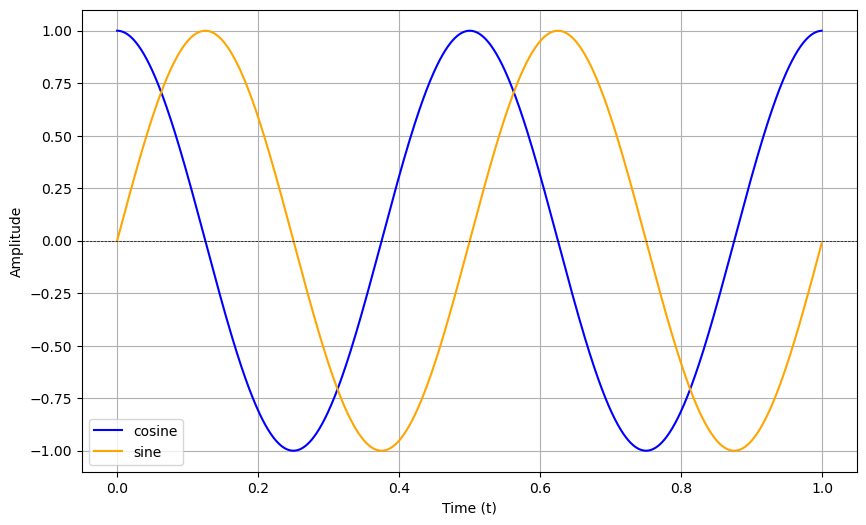

In [53]:
T = 1/2 # Period
omega = 2 * np.pi / T  # Angular frequency
nContinuousSamples = 1000 # for plotting
tPlot = np.linspace(0,1,nContinuousSamples,endpoint = False)
# Generate cosine and sine values
cosine_wave = np.cos(omega * tPlot)
sine_wave = np.sin(omega * tPlot)

# Plot the waves
plt.figure(figsize=(10, 6))
plt.plot(tPlot, cosine_wave, label='cosine', color='blue')
plt.plot(tPlot, sine_wave, label='sine', color='orange')
plt.xlabel('Time (t)')
plt.ylabel('Amplitude')
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.legend()
plt.grid(True)
plt.show()

### Repeating band-limited signals

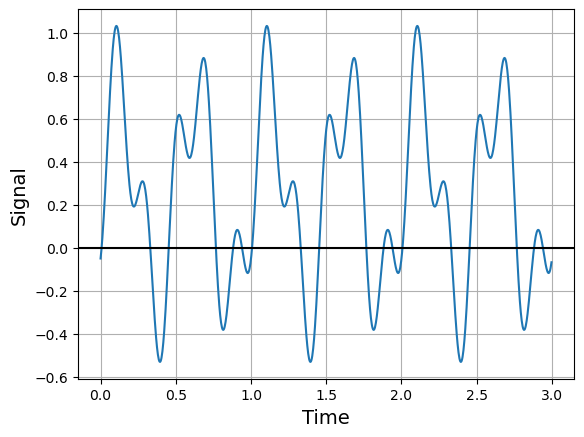

In [54]:
def trignometricSignal(t,c = [],s = []):
	signal = sum(ck * np.cos(k * 2 * np.pi * t) for k, ck in enumerate(c)) + \
		sum(sk * np.sin(k * 2 * np.pi * t) for k, sk in enumerate(s))
	return signal

example = 3
if (example == 1):
	c = [0]
	s = [0, 0.5]
elif (example == 2):
	c = [0]
	s = [0, -0.3]
elif (example == 3):
	c = [0.25, 0 , 0, 0,0,-0.3]
	s = [0, 0, 0.5]
else:
	c = [-0.6*2/np.pi]
	s = [0.6]


T = 3
nContinuousSamples = 1000 # for plotting
tPlot = np.linspace(0,T,nContinuousSamples,endpoint = False)
yPlot = trignometricSignal(tPlot,c,s)
plt.plot(tPlot,yPlot)
plt.axhline(0, color='black')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Signal', fontsize=14)
plt.grid(visible=True)

### Repeating signal that is not band-limited

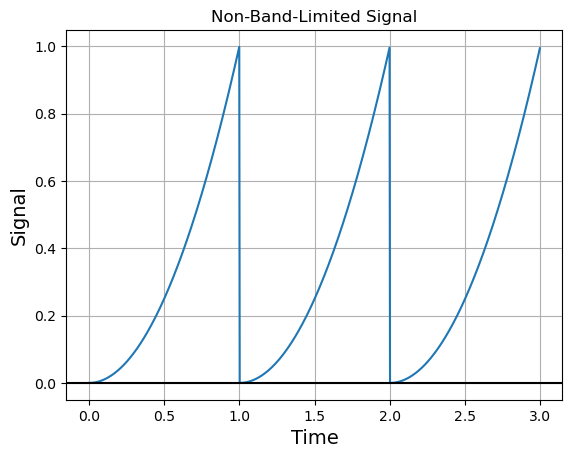

In [55]:
def non_band_limited_signal(t):
    signal = ((t-1) % 1)**2 
    return signal


nContinuousSamples = 1000  # For plotting
tPlot = np.linspace(0, 3, nContinuousSamples, endpoint=False)
yPlot = non_band_limited_signal(tPlot)

plt.plot(tPlot, yPlot)
plt.axhline(0, color='black')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Signal', fontsize=14)
plt.title('Non-Band-Limited Signal')
plt.grid(visible=True)
plt.show()

## Continuous Signal

[0.25, 0, 0, 0, 0, -0.3] [0, 0, 0.5]


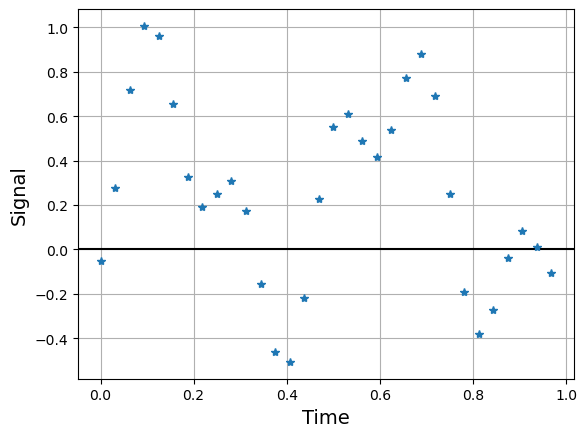

In [56]:

T = 1
c = [0.25, 0 , 0, 0,0,-0.3]
s = [0, 0, 0.5]
M = 32 # We set the number of discrete samples here
t = np.linspace(0,T,M,endpoint = False) # need to eliminate the last point
yDigital = trignometricSignal(t,c,s)
print(c,s)
plt.figure()
plt.axhline(0, color='black')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Signal', fontsize=14)
plt.grid(visible=True)
plt.plot(t,yDigital,'*')

## DFT Signal Processing

Number of samples M: 32


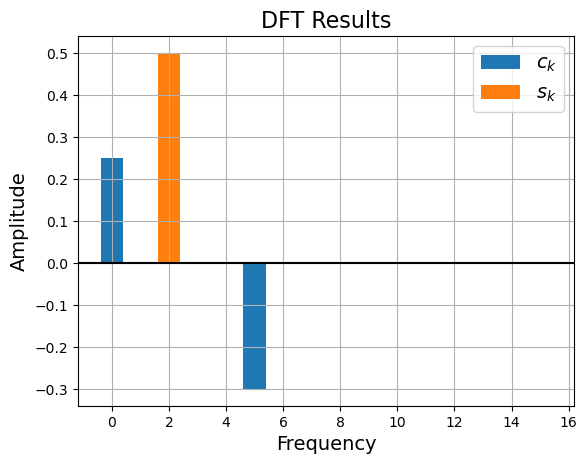

In [57]:
def createDFTMatrix(M):
    """Create DFT matrix using broadcasting."""
    omega = np.exp(-2j * np.pi / M)
    i, j = np.meshgrid(np.arange(M), np.arange(M))
    return omega ** (i * j)

M = len(yDigital)
print("Number of samples M:", M)
DFTMatrix = createDFTMatrix(M)
phi = (1/M)*np.matmul(DFTMatrix,yDigital)
def processDFTResult(phi):
	M = len(phi)
	c = np.zeros(int(M/2))
	s = np.zeros(int(M/2))
	c[0] =  phi[0].real # constant
	c[1:] = (phi[1:int(M/2)]+phi[M-1:int(M/2):-1]).real; # cosine terms
	s =  (phi[M-1:int(M/2):-1] - phi[1:int(M/2)]).imag; # sine terms
	s = np.insert(s, 0,0)
	return [c,s]

[c,s] = processDFTResult(phi)

def plotDFTResults(c,s,M):
	plt.figure()
	plt.bar(list(range(0,int(M/2))),c, label =r"$c_k$")
	plt.bar(list(range(0,int(M/2))),s, label =r"$s_k$")
	plt.legend( fontsize=14)
	plt.axhline(0, color='black')
	plt.xlabel('Frequency', fontsize=14)
	plt.ylabel('Amplitude', fontsize=14)

	plt.title('DFT Results', fontsize=16)
	plt.grid(visible=True)
	plt.show()
      
plotDFTResults(c,s,M)


## QFT with 2 qubits

[[ 0.5+0.j   0.5+0.j   0.5+0.j   0.5+0.j ]
 [ 0.5+0.j   0. +0.5j -0.5+0.j  -0. -0.5j]
 [ 0.5+0.j  -0.5+0.j   0.5+0.j  -0.5+0.j ]
 [ 0.5+0.j  -0. -0.5j -0.5+0.j   0. +0.5j]]
Counts: {'01': 251, '10': 261, '00': 258, '11': 230}


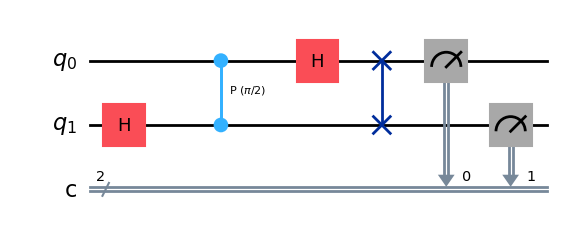

In [58]:
circuit = QuantumCircuit(2, 2)  
circuit.h(1)
circuit.cp(np.pi/2,0,1) 
circuit.h(0) 
circuit.swap(0,1)
print(np.array(Operator(circuit).data))
circuit.measure([0,1], [0,1]) 
counts = simulateCircuit(circuit,1000)
print('Counts:',counts)
circuit.draw('mpl') 

## Qiskit's QFTGate

U from circuit:
 [[ 0.5+0.j   0.5+0.j   0.5+0.j   0.5+0.j ]
 [ 0.5+0.j   0. +0.5j -0.5+0.j  -0. -0.5j]
 [ 0.5+0.j  -0.5+0.j   0.5-0.j  -0.5+0.j ]
 [ 0.5+0.j  -0. -0.5j -0.5+0.j   0. +0.5j]]


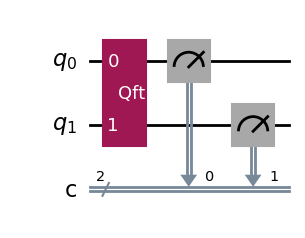

In [59]:
m = 2 # number of qubits
circuit = QuantumCircuit(m, m) 
qft = QFTGate(num_qubits=m)
UFromCircuit = Operator(qft)
print("U from circuit:\n", UFromCircuit.data)
circuit.append(qft, qargs=list(range(m)))
circuit.measure(list(range(m)),list(range(m))) 
circuit.draw('mpl')


## QFTGate with m = 3

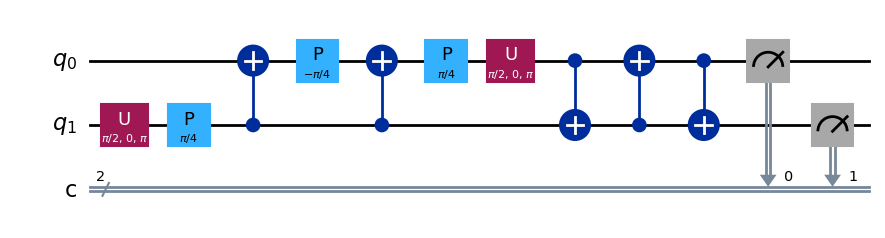

In [60]:
m = 2 # number of qubits
circuit = QuantumCircuit(m, m) 
qft = QFTGate(num_qubits=m)
circuit.append(qft, qargs=list(range(m)))
circuit.measure(list(range(m)),list(range(m))) 
circuit.decompose(reps=2).draw('mpl')


## QFT Signal Processing using Qiskit's QFTGate

Number of qubits: 5


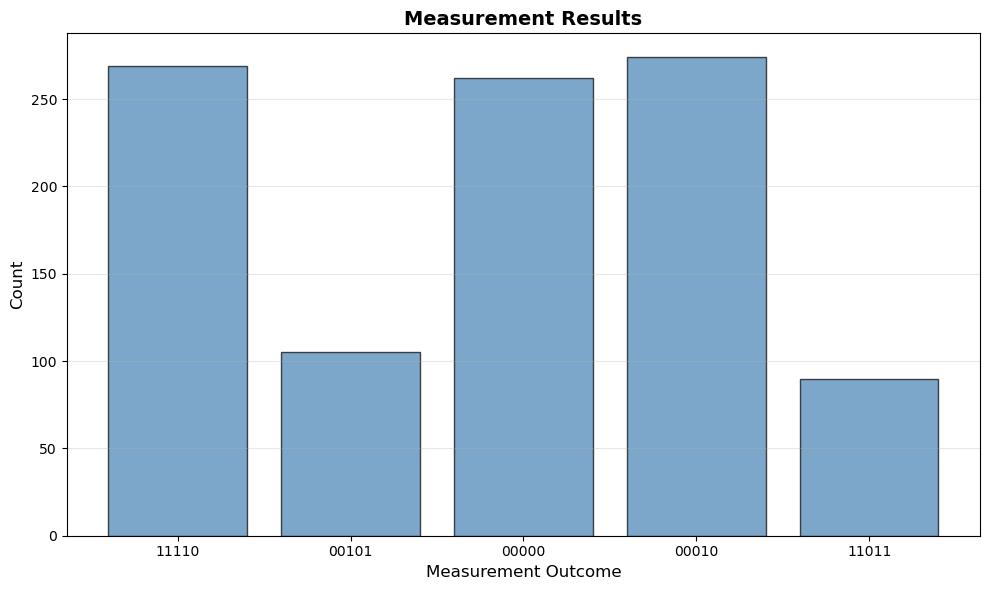

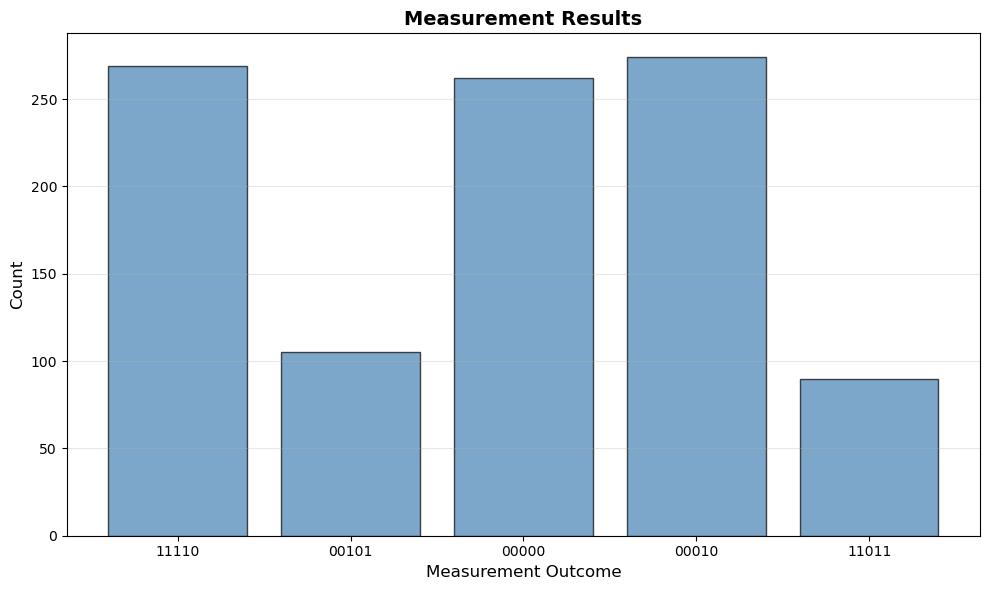

In [61]:
def QFTSignalProcessing(y,shots=1000):
	M = len(y) # length of signal
	m = int(np.log2(M)) # number of qubits
	print('Number of qubits:',m)
	circuit = QuantumCircuit(m, m)  
	q = Statevector(y/np.linalg.norm(y)) 
	circuit.prepare_state(q,list(range(m)),'Prepare q')
	qftCircuit = QFTGate(num_qubits=m)
	circuit.append(qftCircuit, qargs=list(range(m)))
	circuit.measure(list(range(m)),list(range(m))) 
	counts = simulateCircuit(circuit,shots=shots)
	
	return counts
M = 32
t = np.linspace(0,1,M,endpoint = False) # need to eliminate the last point
y = trignometricSignal(t,c,s)
shots = 1000
counts = QFTSignalProcessing(y,shots)
plot_measurement_results(counts)

### Processing QFT results

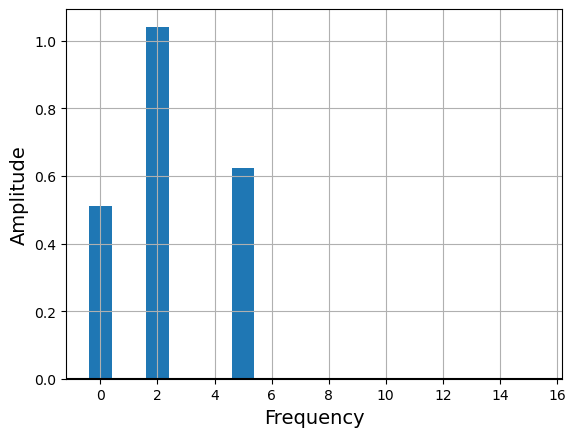

In [62]:
def processQFTResult(counts,shots):
	phi = np.zeros(M)
	for i in counts:
		freq = int(i, 2)
		phi[freq] = np.sqrt(counts[i]/shots)
	ampl = (phi[1:int(M/2)])+(phi[M-1:int(M/2):-1]);
	ampl = np.insert(ampl, 0,phi[0].real)
	return ampl
	
ampl = processQFTResult(counts,shots)

plt.figure()
plt.bar(list(range(0,int(M/2))),ampl)
plt.axhline(0, color='black')
plt.xlabel('Frequency', fontsize=14)
plt.ylabel('Amplitude', fontsize=14)
plt.grid(visible=True)


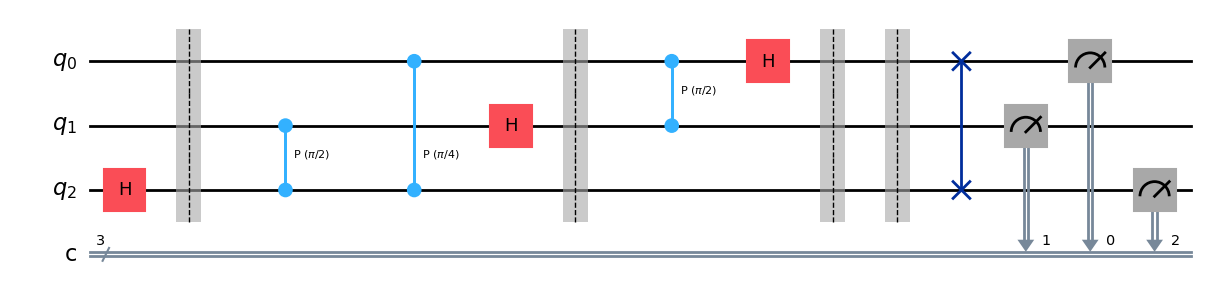

In [63]:
def myQFT(m): # m is the # of qubits
    q = QuantumRegister(m, 'q')
    c = ClassicalRegister(m,'c')
    circuit = QuantumCircuit(q,c)
    for k in range(m):
        kk = m - k
        circuit.h(q[kk-1])
        circuit.barrier()
        for i in reversed(range(kk-1)):
            circuit.cp(2*np.pi/2**(kk-i),q[i], q[kk-1])
      
    circuit.barrier()  
    for i in range(m//2):
        circuit.swap(q[i], q[m-i-1])
    return circuit

m = 3
circuit = myQFT(m)
circuit.measure(list(range(m)),list(range(m))) 
circuit.draw('mpl') 

### QFT Matrix Verification

In [64]:
def createQFTMatrix(M):
    QFTMatrix = np.zeros((M,M), dtype=complex)
    omega = np.exp(1j*(2*np.pi/M))
    for i in range(M):
        for j in range(M):
            QFTMatrix[i][j] = omega**(i*j)
    return QFTMatrix/np.sqrt(M)


In [65]:
m = 2
circuit = myQFT(m)
UFromCircuit = Operator(circuit)
UExact = createQFTMatrix(2**m)
print("Error: ", round(np.linalg.norm(UFromCircuit-UExact),10))

Error:  0.0


## 1D Poisson Equation

### Forcing function f(x) and solution u(x)

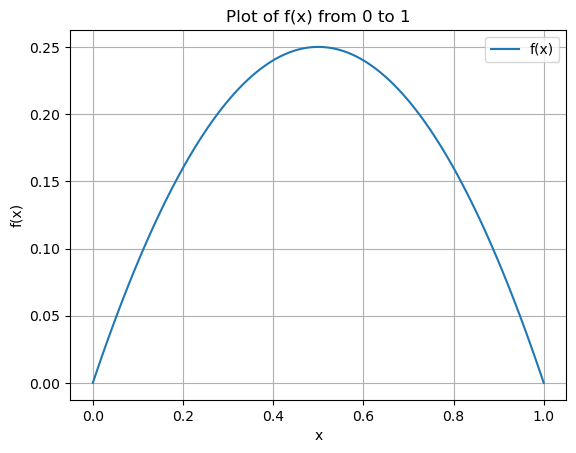

In [66]:
def Poisson1DForcingFunction(x, L = 1):
    example = 1
    if (example == 1):  
       return x*(L - x)
    elif (example == 2):
        alpha_0 = 0.3
        alpha_1 = 0.1
        alpha_2 = -0.1772
        return np.exp(-((x - alpha_0) ** 2) / (alpha_1 ** 2)) + alpha_2

def Poisson1DSolution(x, L = 1):
     example = 1
     if (example == 1):
         return -x**3/6 + x**4/12 + x/12
     elif (example == 2):
        alpha_0 = 0.3
        alpha_1 = 0.1
        alpha_2 = -0.1772
        alpha_3 = 0.053
        alpha_4 = -0.0266
        term1 = (alpha_1 * np.sqrt(np.pi) / 2) * (x - alpha_0) * scipy.special.erf((x - alpha_0) / alpha_1)
        term2 = (alpha_1 / (np.sqrt(np.pi))) * np.exp(-((x - alpha_0)**2) / alpha_1**2)
        term3 = (alpha_2 * x**2) / 2
        term4 = alpha_3 * x + alpha_4
        return term1 + term2 + term3 + term4
     
# Generate x values from 0 to 1
x = np.linspace(0, 1, 100)

# Calculate f(x) for each x
f = Poisson1DForcingFunction(x)

# Create the plot
plt.plot(x, f, label="f(x)")
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Plot of f(x) from 0 to 1')
plt.grid(True)
plt.legend()
plt.show()

### Digital signal of f

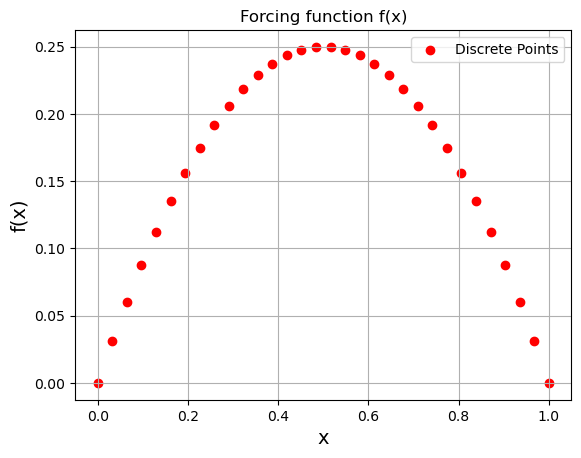

In [67]:
M = 32  # discretization points
L = 1  # domain length
nShots = 1000
x = np.linspace(0, L, M)
fj = Poisson1DForcingFunction(x)
plt.figure()
plt.scatter(x, fj, color='red', label="Discrete Points")
plt.xlabel('x', fontsize=14)
plt.ylabel('f(x)', fontsize=14)
plt.title('Forcing function f(x)')
plt.grid(visible=True)
plt.legend()

### DFT of f(x)

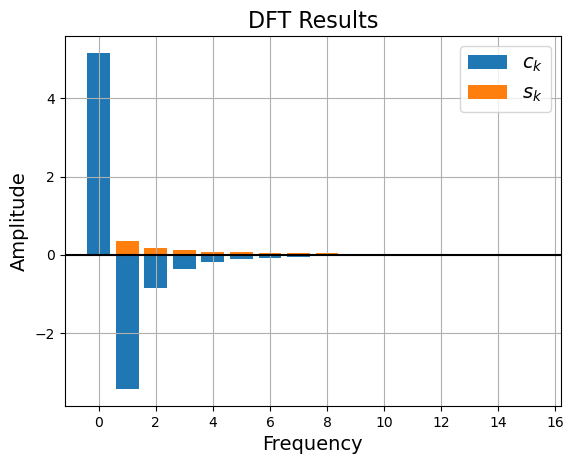

In [68]:
DFTMatrix = createDFTMatrix(M)
phi = np.matmul(DFTMatrix,fj)

[c,s] = processDFTResult(phi)

plotDFTResults(c,s,M)

### QFT of f(x)

Number of qubits: 5


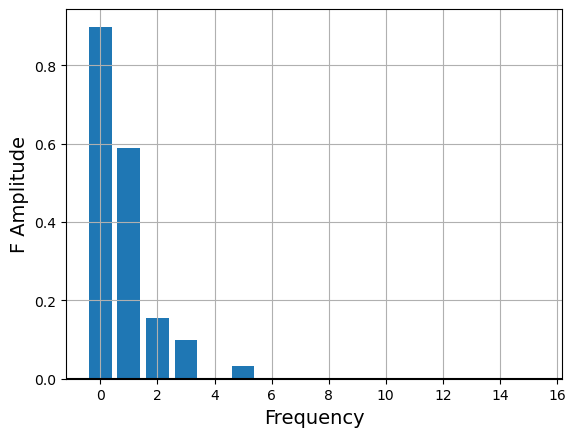

In [69]:
fj_norm = np.linalg.norm(fj) # store for scaling

counts = QFTSignalProcessing(fj, nShots)
Fk = processQFTResult(counts, nShots)


plt.figure()
plt.bar(list(range(0,int(M/2))),Fk)
plt.axhline(0, color='black')
plt.xlabel('Frequency', fontsize=14)
plt.ylabel('F Amplitude', fontsize=14)
plt.grid(visible=True)

### Regenerate f(x) from QFT results

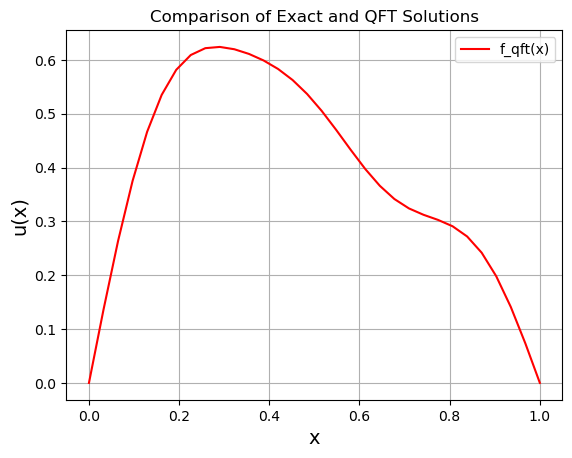

In [70]:
f_qft = np.sum([Fk[k] * np.sin(np.pi * k * x/L) for k in range(1, len(Fk))], axis=0)
plt.figure()
plt.plot(x, f_qft, label='f_qft(x)', color='red')
plt.xlabel('x', fontsize=14)
plt.ylabel('u(x)', fontsize=14)
plt.title('Comparison of Exact and QFT Solutions')
plt.legend()
plt.grid(visible=True)

### Solution u(x)

1.0165294951093038


Text(0, 0.5, 'U Amplitude')

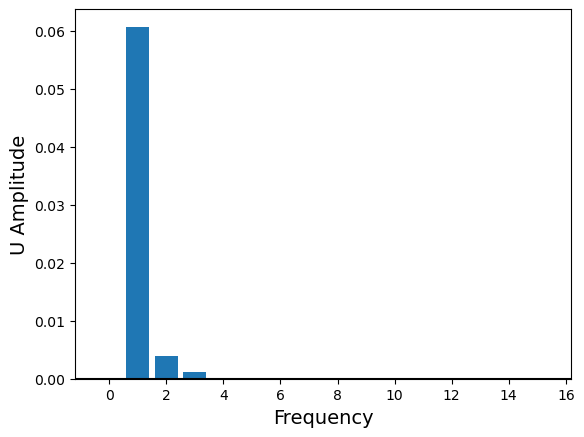

In [71]:
print(fj_norm)
Uk = np.zeros(len(Fk))
for k in range(1, len(Fk)):
    Uk[k] = fj_norm * Fk[k] / (np.pi * k*L)**2

plt.figure()
plt.bar(list(range(0,int(M/2))),Uk)
plt.axhline(0, color='black')
plt.xlabel('Frequency', fontsize=14)
plt.ylabel('U Amplitude', fontsize=14)



### Hybrid solution

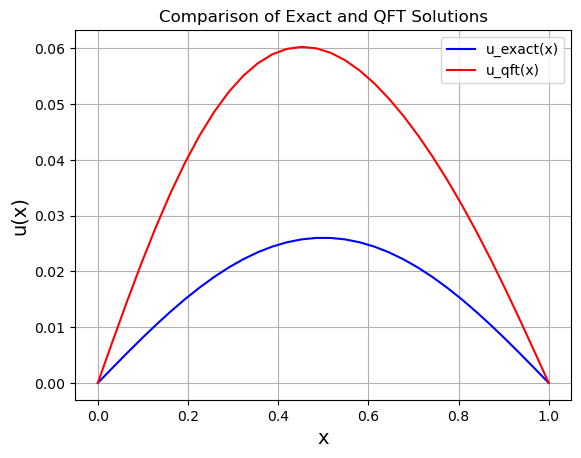

In [72]:
u_qft = np.sum([Uk[k] * np.sin(np.pi * k * x/L) for k in range(1, len(Uk))], axis=0)
u_exact = Poisson1DSolution(x, L)
plt.figure()
plt.plot(x, u_exact, label='u_exact(x)', color='blue')
plt.plot(x, u_qft, label='u_qft(x)', color='red')
plt.xlabel('x', fontsize=14)
plt.ylabel('u(x)', fontsize=14)
plt.title('Comparison of Exact and QFT Solutions')
plt.legend()
plt.grid(visible=True)

## Inverse QFT

<IPython.core.display.Latex object>

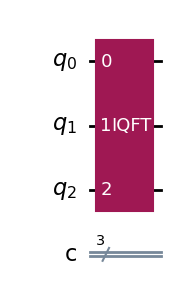

In [73]:
m = 3 # number of qubits
circuit = QuantumCircuit(m, m) 
iqft = QFTGate(num_qubits=m).inverse()
iqft._name = 'IQFT'
circuit.append(iqft, qargs=list(range(m)))

psi = Statevector(circuit)
display(psi.draw('latex'))
circuit.draw('mpl')